In [47]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

import plotly.express as px

import os
import sys

from scipy.optimize import minimize
# code to manage where are lunch the file
if str(os.getcwd()).split("/")[-1] == "notebooks":
    sys.path.insert(1, os.path.realpath(os.path.pardir))
    path_b = "../"
else:
    path_b ='./'
import config as c

In [19]:
windows = c.windows
number_crypto = c.number_cyptos
market_cap = c.market_cap

df_name_index = pd.read_csv(f"{path_b}data/processed/first_{number_crypto}_crypto_list.csv", index_col=0)
df = pd.read_csv(f"{path_b}data/processed/market_cap_crypto.csv", index_col=0)
df['date'] = pd.to_datetime(df.index)
df['date'] = df['date'].dt.date
df.index = df['date']
del df['date']

df_close_price = pd.read_csv(f'{path_b}data/processed/close_price_crypto.csv', index_col=0)
df_close_price['date'] = pd.to_datetime(df_close_price.index)
df_close_price['date'] = df_close_price['date'].dt.date
df_close_price.index = df_close_price['date']
del df_close_price['date']

## use market cap file

df_market_cap = pd.read_csv(f'{path_b}data/processed/crypto_date_marketcap_sorted.csv', index_col=0)


df_market_cap_first_20 = df_market_cap.iloc[:number_crypto]

#select last date
first_date = df_market_cap_first_20['first_date_marketcap'].tail(1).values

first_date_final = pd.to_datetime(first_date[0])

df_final_data = df_close_price.drop(df_close_price[df_close_price.index < first_date_final].index)
df_final_data = df_final_data[df_market_cap_first_20['crypto_name']]

df_final_market_cap = df.drop(df[df.index < first_date_final].index)
df_final_market_cap = df_final_market_cap[df_market_cap_first_20['crypto_name']]

df_final_data_return = np.log(df_final_data/df_final_data.shift(1)).dropna()

/Users/guillaume/MyProjects/HECProject/qarm_2/project/venv/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [21]:
df_final_market_cap['sum'] = df_final_market_cap.sum(axis=1)
df_final_market_cap.head(4)

,bitcoin,litecoin,ripple,nxt,dogecoin,digibyte,dash,monero,bitshares,stellar,...,nem,ethereum,siacoin,decred,lisk,digixdao,steem,bytecoin-bcn,augur,sum
date,,,,,,,,,,,,,,,,,,,,,
2016-05-14,7.083394e+09,183599238.0,211772135.0,6426131.0,24145165.0,1708244.0,44791127.0,9944371.0,9225519.0,9771366.0,...,12919319.0,819487227.0,1515312.0,2165140.0,0.0,24270000.0,10635992.0,5954338.0,0.0,8.462139e+09
2016-05-15,7.114462e+09,186088259.0,211328954.0,6307651.0,24094648.0,1691856.0,45151179.0,9765706.0,9139498.0,9666590.0,...,13233599.0,797607882.0,1652027.0,2196125.0,0.0,20386000.0,10920352.0,6151077.0,0.0,8.470257e+09
2016-05-16,7.063120e+09,183559577.0,209976746.0,6256861.0,23899556.0,1673920.0,46941599.0,9700899.0,9359015.0,9455062.0,...,13426469.0,894750992.0,1643868.0,3288733.0,0.0,20067200.0,10304691.0,6463091.0,0.0,8.514248e+09
2016-05-17,7.058821e+09,182548346.0,210021030.0,6252851.0,23597336.0,1791142.0,47801242.0,9641475.0,9280756.0,9284183.0,...,13188779.0,977439936.0,2393223.0,2898258.0,0.0,20152400.0,11820225.0,5951348.0,0.0,8.593200e+09


In [30]:
columns = df_final_market_cap.columns[:-1]

df_weight_cap_weigthed= df_final_market_cap[columns]

for column in df_weight_cap_weigthed.columns:
    df_weight_cap_weigthed[column] = df_weight_cap_weigthed[column] / df_final_market_cap['sum']

/var/folders/hv/kjs_mg3s28b_rhljhxq6r2f80000gp/T/ipykernel_58445/4130203543.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weight_cap_weigthed[column] = df_weight_cap_weigthed[column] / df_final_market_cap['sum']


Text(0.5, 1.0, 'Cap_weighted (Evolution of weights)')

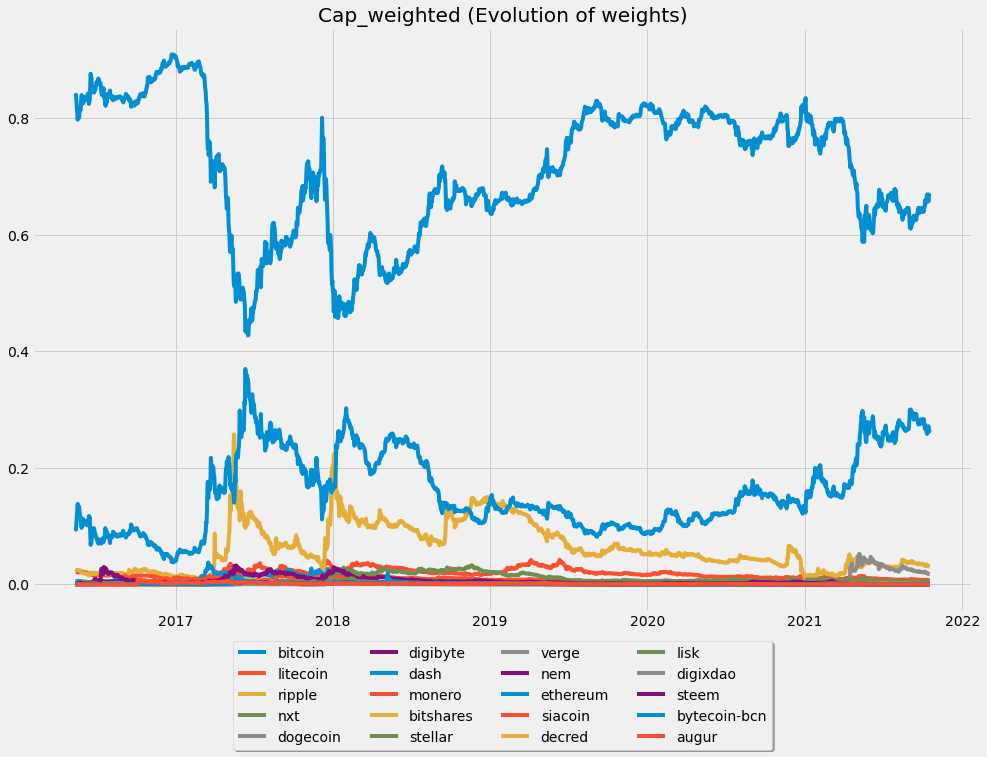

In [36]:
plt.figure(figsize=(15,10))
plt.plot(df_weight_cap_weigthed)
plt.legend(df_weight_cap_weigthed, loc="lower center", fancybox=True, shadow=True,ncol=4,bbox_to_anchor=(0.5, -0.25))
plt.title("Cap_weighted (Evolution of weights)")

In [60]:
# voir pour comparer bitcoin avec les autres crypto (peut être agréger les cryptos)
fig = px.line(df_weight_cap_weigthed, x=df_weight_cap_weigthed.index, y=df_weight_cap_weigthed.columns, title="Cap_weighted (Evolution of weights)",labels={'value':'weight'})
fig.show()

In [61]:
fig = px.scatter(df_weight_cap_weigthed['bitcoin'], x=df_weight_cap_weigthed['bitcoin'].index, y='bitcoin', title="Bitcoin (% of market cap)",labels={'bitcoin': "% of market cap"})
fig.show()

In [50]:
print(df_final_data_return.shape)
print(df_weight_cap_weigthed.shape)
print(df_weight_cap_weigthed.shape[0] - df_final_data_return.shape[0])

diff = df_weight_cap_weigthed.shape[0] - df_final_data_return.shape[0]

(1884, 20)
(1983, 20)
99


In [98]:
port_cap_weigthed = pd.DataFrame(np.sum(np.multiply(df_final_data_return, df_weight_cap_weigthed.iloc[diff:]),1)[2:],columns=['perf'])
port_cap_weigthed = port_cap_weigthed.drop(port_cap_weigthed[port_cap_weigthed.index == pd.to_datetime("2018-05-10") ].index)

/var/folders/hv/kjs_mg3s28b_rhljhxq6r2f80000gp/T/ipykernel_58445/2701388527.py:1: FutureWarning:

Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.

/Users/guillaume/MyProjects/HECProject/qarm_2/project/venv/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



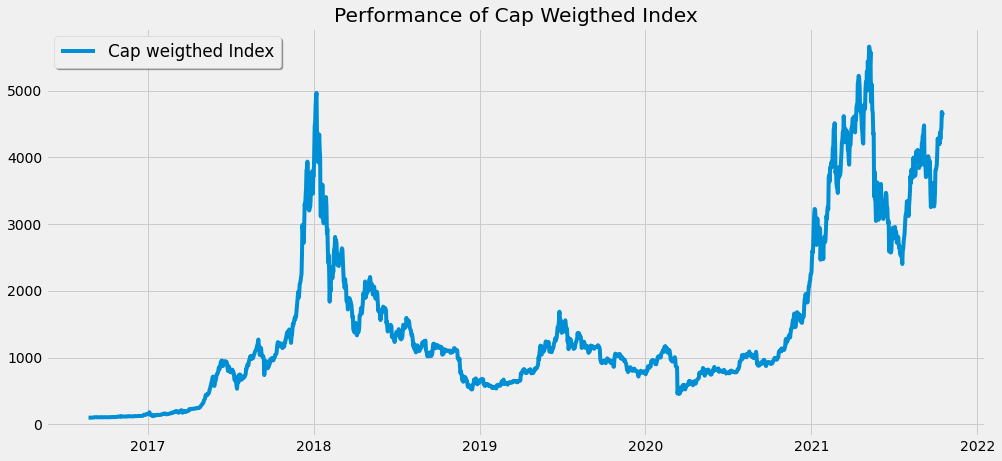

In [111]:
plt.figure(figsize=(15,7))
plt.plot((port_cap_weigthed['perf']+1).cumprod()*100)
plt.legend(['Cap weigthed Index'],loc='upper left',fontsize='large',fancybox=True, shadow=True)
plt.title('Performance of Cap Weigthed Index')
plt.show()

In [113]:
perf = (port_cap_weigthed['perf'].add(1)).cumprod()*100
fig = px.line(perf, x=perf.index, y=perf, title="Performance Cap Weigthed Index", labels={'y':'Performance (basis 100)'})
fig.show()

In [89]:
df_test = pd.DataFrame((port_cap_weigthed+1).cumprod())
df_test.columns = ['cum_perf']
# df_test
df_test.drop(df_test[df_test.cum_perf != np.inf ].index)
#2018-05-09	-> bug à 2018-05-10 (inf)

,cum_perf
date,
2018-05-10,inf
2018-05-11,inf
2018-05-12,inf
2018-05-13,inf
2018-05-14,inf
...,...
2021-10-13,inf
2021-10-14,inf
2021-10-15,inf


/Users/guillaume/MyProjects/HECProject/qarm_2/project/venv/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



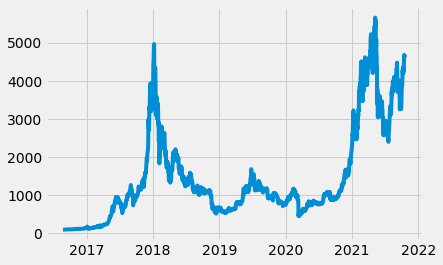

In [96]:
df_perf_test = pd.DataFrame(port_cap_weigthed)
df_perf_test.columns = ['perf']
final = df_perf_test.drop(df_perf_test[df_perf_test.index == pd.to_datetime("2018-05-10") ].index)

plt.plot((final['perf'].add(1).cumprod()*100))
